# Libraries

In [1]:
import os
import sys
import glob

import numpy as np
import pandas as pd

from astropy import units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

from reproject import reproject_from_healpix, reproject_adaptive
import healpy as hp


from spectral_cube import SpectralCube

import pickle
import shutil

import matplotlib.pyplot as plt
import matplotlib        as mpl
from matplotlib.patches import Ellipse
from matplotlib.ticker import AutoMinorLocator

import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

from pathlib import Path

import seaborn as sns

In [2]:
# Set the font family for math symbols
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# Display all colums
pd.set_option('display.max_columns', None)

# Paths

In [ ]:
base = Path.home()
askap = base / 'ANU' / 'ASKAP'
data_path = askap / 'data'
LMC_data_path = data_path / 'LMC'
LMC_GASKAP_data = LMC_data_path / 'lmc_gaskap'

cont_data_path = data_path / 'cont'
LMC_bridge_data = LMC_data_path / 'bridge'
GASS_em_spectra_path = LMC_data_path / 'neighbour_emission_spectra'
GASS_data_path = LMC_data_path / 'GASS'

SMC = askap / 'SMC'
SMC_data_path = data_path / 'SMC'
SMC_fg_data_path = SMC_data_path / 'fg'
SMC_fg_abs_data_path = SMC_fg_data_path / 'spectra'

hires_data = LMC_data_path / 'hires'
em_spectra_path = hires_data / 'neighbour_emission_spectra'
hires_results = hires_data / 'results'
hires_em_data = hires_data / 'cube'
hires_em_subcube_data = hires_em_data / 'subcubes'
hires_abs_data = hires_data / 'abs'
hires_em_profile_path = hires_data / 'em_profiles'
abscatv2_data_path = hires_data / 'abscatv2'
abs_dr3_data_path = hires_data / 'absdr3'

mwmc_data_path = data_path / 'mwmc'
mwmc_gaskap_path = mwmc_data_path / 'lmc_gaskap'

bridge_hires_abs_data = hires_abs_data / 'bridge'
LMC_hires_abs_data = hires_abs_data / 'lmc'

abs_path = mwmc_data_path / 'absorption'

abs_path = mwmc_data_path / 'absorption'
BIGHICAT_data_path = data_path / 'BIGHICAT'

# Absorption catalog Phase 2 version 2
print(abscatv2_data_path)

# Absorption catalog  version 3
print(abs_dr3_data_path)

# Modules

In [ ]:
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.abspath(Path(script_dir) / os.pardir)
print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
gaussfit_dir = Path(parent_dir) / 'gaussfit'
print('gaussfit_dir: ', gaussfit_dir)
sys.path.append(parent_dir)
module_dir = Path(parent_dir) / 'gaussfit' / 'modules'
sys.path.append(module_dir)

print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
print('gaussfit_dir: ', gaussfit_dir)

In [5]:
import libs.fitlibs as fitlibs
import libs.functions as fcn
import config.config as cf
from mpfit import mpfit

# For plotting

In [6]:
# Approximate locations of LMC and SMC
SMC_xcirc, SMC_ycirc = cf.SMC['circ']
LMC_xcirc, LMC_ycirc = cf.LMC['circ']

In [7]:
# Circle
def hcircle(x, y, r):
    theta = np.linspace(1.365*np.pi, 1.55*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

# Circle
def vcircle(x, y, r):
    theta = np.linspace(1.73*np.pi, 1.87*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_ch = 295.
gb_ch = 21.8
R_ch = 59.

gl_cv = 238.
gb_cv = -5.
R_cv = 57.


ch_xcirc, ch_ycirc = hcircle(gl_ch, gb_ch, R_ch)
cv_xcirc, cv_ycirc = vcircle(gl_cv, gb_cv, R_cv)

In [8]:
lmc_glon = [270., 308.]
lmc_glat = [-48.99, -26.45]

gl_boundary = np.array([297., 302., 305., 308., 305., 297., 298., 295., 292., 294., 285., 283.5, 271.5, 271., 288.5, 290., 295., 297.])
gb_boundary = np.array([-36., -35., -40., -42.5, -48.5, -46.2, -43., -38.25, -39.8, -44.5, -45.9, -40.8, -41.5, -29., -26.9, -32., -31., -36.])

# GASKAP: Read table DR3

In [ ]:
spectra_filename = mwmc_data_path / 'gaskap_phase2_unique_spectra_v0.2c.csv'
spectra_filename = abs_dr3_data_path / 'gaskap_abs_spectra_dr3b.csv'
print(spectra_filename)
df = pd.read_csv(spectra_filename)
nsrcs, ncols = df.shape
print(f'Number of rows {nsrcs},\n Number of columns: {ncols}')
df.head(5)

In [58]:
field_ids = df['sbid'].unique()
print(f'Number of fields: {len(field_ids)}')
fields = ['sb'+str(x) for x in field_ids]
print('Fields: ', ', '.join([str(x) for x in field_ids]))
print()
print('Number of sources/sightlines in each field:')
df.groupby(['sbid'])['sbid'].count()

Number of fields: 10
Fields:  30665, 33047, 38814, 38791, 38845, 38215, 38373, 38466, 38758, 38509

Number of sources/sightlines in each field:


sbid
30665    346
33047    290
38215    268
38373    257
38466    261
38509    270
38758    200
38791    297
38814    242
38845    283
Name: sbid, dtype: int64

In [59]:
print(f"Types of ratings: {df['rating'].unique()}")

Types of ratings: ['A' 'B' 'C' 'D']


In [60]:
df.groupby(['rating'])['comp_name'].count()

rating
A     294
B    1869
C     343
D     208
Name: comp_name, dtype: int64

In [61]:
# All sources
sources = df['comp_name'].unique()
print(f'Number of sources toward LMC: {len(sources)}')
print(f'Sources: {sources}')

Number of sources toward LMC: 2714
Sources: ['J005611-710706' 'J011049-731427' 'J011056-731406' ... 'J045340-751015'
 'J060302-715904' 'J051901-715032']


In [62]:
df[ df['has_mw_abs'] == True ]['comp_name'].unique().shape

(473,)

In [63]:
field_ids = df['sbid'].unique()
nfields = len(field_ids)
print(f'Number of fields: {nfields}')
fields = ['sb'+str(x) for x in field_ids]
print('Fields: ', ', '.join([str(x) for x in field_ids]))
print()
print('Number of sources/sightlines in each field:')
df.groupby(['sbid'])['sbid'].count()

Number of fields: 10
Fields:  30665, 33047, 38814, 38791, 38845, 38215, 38373, 38466, 38758, 38509

Number of sources/sightlines in each field:


sbid
30665    346
33047    290
38215    268
38373    257
38466    261
38509    270
38758    200
38791    297
38814    242
38845    283
Name: sbid, dtype: int64

In [64]:
src_ra = df['ra'].values
src_dec = df['dec'].values

src_gl = df['glon'].values
src_gb = df['glat'].values

src_list = df['comp_name'].values
print(len(src_list))

2714


In [65]:
# df.groupby(["sbid"])["sbid"].count()
fields_series = df['sbid'].value_counts()
fields_series

30665    346
38791    297
33047    290
38845    283
38509    270
38215    268
38466    261
38373    257
38814    242
38758    200
Name: sbid, dtype: int64

In [66]:
# All sources
sources = df['comp_name'].unique()
print(f'Number of sources toward LMC: {len(sources)}')
print(f'Sources: {sources}')

Number of sources toward LMC: 2714
Sources: ['J005611-710706' 'J011049-731427' 'J011056-731406' ... 'J045340-751015'
 'J060302-715904' 'J051901-715032']


In [67]:
df[ df['has_mw_abs'] == True ]['comp_name'].unique().shape

(473,)

In [68]:
sbid = fields_series.index.to_list()
print(f'Fields: {sbid}')
sbid_counts = fields_series.values
print(f'sbid_counts: {sbid_counts}')

Fields: [30665, 38791, 33047, 38845, 38509, 38215, 38466, 38373, 38814, 38758]
sbid_counts: [346 297 290 283 270 268 261 257 242 200]


Number of sightlines: 2714


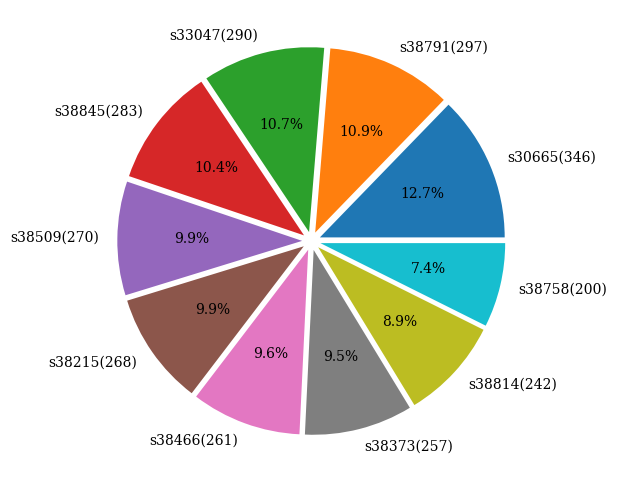

In [69]:
print(f'Number of sightlines: {sbid_counts.sum()}')

plt.figure(figsize=(6,6))
colors = ['g', 'r']
labels = ['s' + str(sbid[i]) + '(' + str(sbid_counts[i]) + ')' for i in range(len(sbid))]
explode = [0.05]*nfields
plt.pie(df['sbid'].value_counts(normalize=True)*100, colors=None, labels=labels, explode=explode, autopct='%1.1f%%', shadow=False)
plt.title('')
plt.show()

In [70]:
print(f"Types of ratings: {df['rating'].unique()}")

rating_info = df['rating'].value_counts()
rating_types = rating_info.index.to_list()
print(f'Rating types: {rating_types}')

rating_counts = rating_info.values
print(f'Rating counts: {rating_counts}')

n_ratings = len(rating_types)

Types of ratings: ['A' 'B' 'C' 'D']
Rating types: ['B', 'C', 'A', 'D']
Rating counts: [1869  343  294  208]


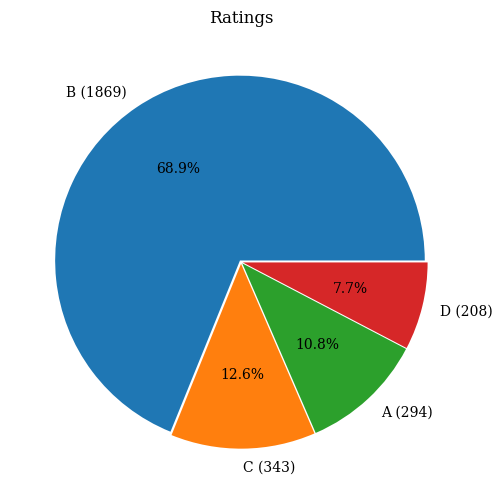

In [71]:
colors = ['g', 'r']
explode = [0.01]*n_ratings
labels = [rating_types[i]+' (' + str(rating_counts[i]) + ')' for i in range(n_ratings)]

plt.figure(figsize=(6,6))
plt.pie(df['rating'].value_counts(normalize=True)*100,
        colors=None,
        labels=labels,
        explode=explode,
        autopct='%1.1f%%',
        shadow=False)

plt.title('Ratings')
plt.show()

# Dectections

In [72]:
det_df = df[df.mw_detection]
print(det_df.shape)
ndet = det_df.shape[0]

det_src_list = det_df.comp_name.values
det_src_gl = det_df.glon.values
det_src_gb = det_df.glat.values

(462, 33)


In [73]:
nsrcs

2714

# Saturated sources

In [74]:
sat_df = df[df.saturated]
sat_df

,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,has_mw_abs,has_other_abs,semi_maj_axis,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
1462,337,J033454-765712,SB38509_component_225a,53.727799,-76.953516,292.330669,-36.594138,B,18.247999,27.194000,0.000092,0.156399,1.429323,2.623784,1.394428,89.0,-0.034895,5.213831,5.0,3.462193,True,False,6.060,4.850,176.830002,2.441017e+20,False,0.009408,M355-07,38509,38509,False,True
1565,244,J042645-754356,SB38758_component_131a,66.689082,-75.732415,288.902586,-34.845820,C,31.113001,34.987999,0.000157,0.162031,1.613970,2.473195,1.464693,71.0,-0.149277,4.435788,5.0,3.546635,True,False,5.065,4.260,55.369999,2.455275e+20,False,0.011692,M355-02,38758,38758,False,True
1576,287,J040852-721901,SB38758_component_156a,62.220323,-72.317006,286.012697,-37.626103,C,25.906000,32.137001,0.000112,0.213407,1.647171,2.575310,1.460707,58.0,-0.186464,6.679087,5.0,3.755119,True,False,5.330,4.465,65.930000,1.192325e+20,False,0.012949,M355-02,38758,38758,False,True
1603,362,J035607-735425,SB38758_component_210a,59.030638,-73.907151,288.329734,-37.514114,C,19.132999,24.773001,0.000095,0.187999,1.734289,1.665929,1.650538,88.0,-0.083751,0.249388,5.0,3.669418,True,False,5.475,4.540,42.380001,2.405412e+20,False,0.009862,M355-02,38758,38758,False,True
2040,350,J040428-692618,SB38814_component_209a,61.118584,-69.438462,283.100898,-39.422719,C,20.837000,24.475000,0.000103,0.253419,1.949616,1.446376,1.796941,104.0,-0.152676,-2.814305,5.0,3.781250,True,False,5.405,4.100,54.599998,4.971288e+19,False,0.002216,M355+02,38814,38814,False,True
2147,110,J053821-771905,SB38845_component_63a,84.590892,-77.318269,288.944277,-30.404877,C,55.574001,69.519997,0.000205,0.183898,1.653708,1.772035,1.596568,103.0,-0.057140,3.886166,5.0,3.657670,True,False,5.320,4.570,40.900002,1.832042e+20,False,0.014752,M000-02,38845,38845,False,True
2148,111,J053821-771856,SB38845_component_63b,84.588785,-77.315712,288.941479,-30.405840,C,42.478001,54.595001,0.000196,0.174150,1.647953,1.944636,1.559646,94.0,-0.088307,3.884371,5.0,3.603101,True,False,5.410,4.620,44.450001,1.832042e+20,False,0.013924,M000-02,38845,38845,False,True
2234,274,J045859-754650,SB38845_component_171b,74.746789,-75.780713,287.956296,-33.026360,B,16.715000,24.173000,0.000146,0.131266,1.445027,2.826273,1.377659,91.0,-0.067368,4.827469,5.0,3.343459,True,False,5.660,4.970,31.719999,2.820502e+20,False,-0.003037,M000-02,38845,38845,False,True
2324,442,J061332-742400,SB38845_component_289a,93.385278,-74.400240,285.348760,-28.592825,C,15.986000,25.902000,0.000069,0.139208,2.103440,1.627650,1.800502,177.0,-0.302938,2.906457,5.0,3.363643,True,False,6.240,5.050,74.209999,7.335645e+19,True,0.006051,M000-02,38845,38845,False,True
2383,0,J032723-744843,SB38509_component_138a,51.846610,-74.812165,290.789024,-38.410531,C,27.474001,28.622999,0.000132,0.282384,2.663230,1.603476,2.022952,67.0,-0.640278,2.955655,5.0,4.080212,True,False,4.855,4.230,41.660000,0.000000e+00,False,-0.010134,M355-07,"38466,38509,38758",38509,False,True


In [75]:
sat_gl = sat_df.glon.values
sat_gb = sat_df.glat.values

In [76]:
nsat = len(sat_gl)
nsat

12

# GASKAP Tbpeak

In [80]:
# # Tb,peak map
tbpeak_data_file = LMC_data_path / 'Tb_peak_combined_mw_full_hnv.fits'

tbpeak_map, hdr = fits.getdata(tbpeak_data_file, header=True)
wcs2D = WCS(hdr)
print(wcs2D)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 56.755694111202  -72.799170553189  
CRPIX : 2550.0  1750.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00666666  0.00666666  
NAXIS : 5100  3500


In [89]:
outfile1 = LMC_data_path / 'Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits'
nx1 = 5100
nx2 = 3500

In [ ]:
tbpeak_data, fg_hdr = fits.getdata(outfile1, header=True)
print(tbpeak_data.shape)
fg_hdr

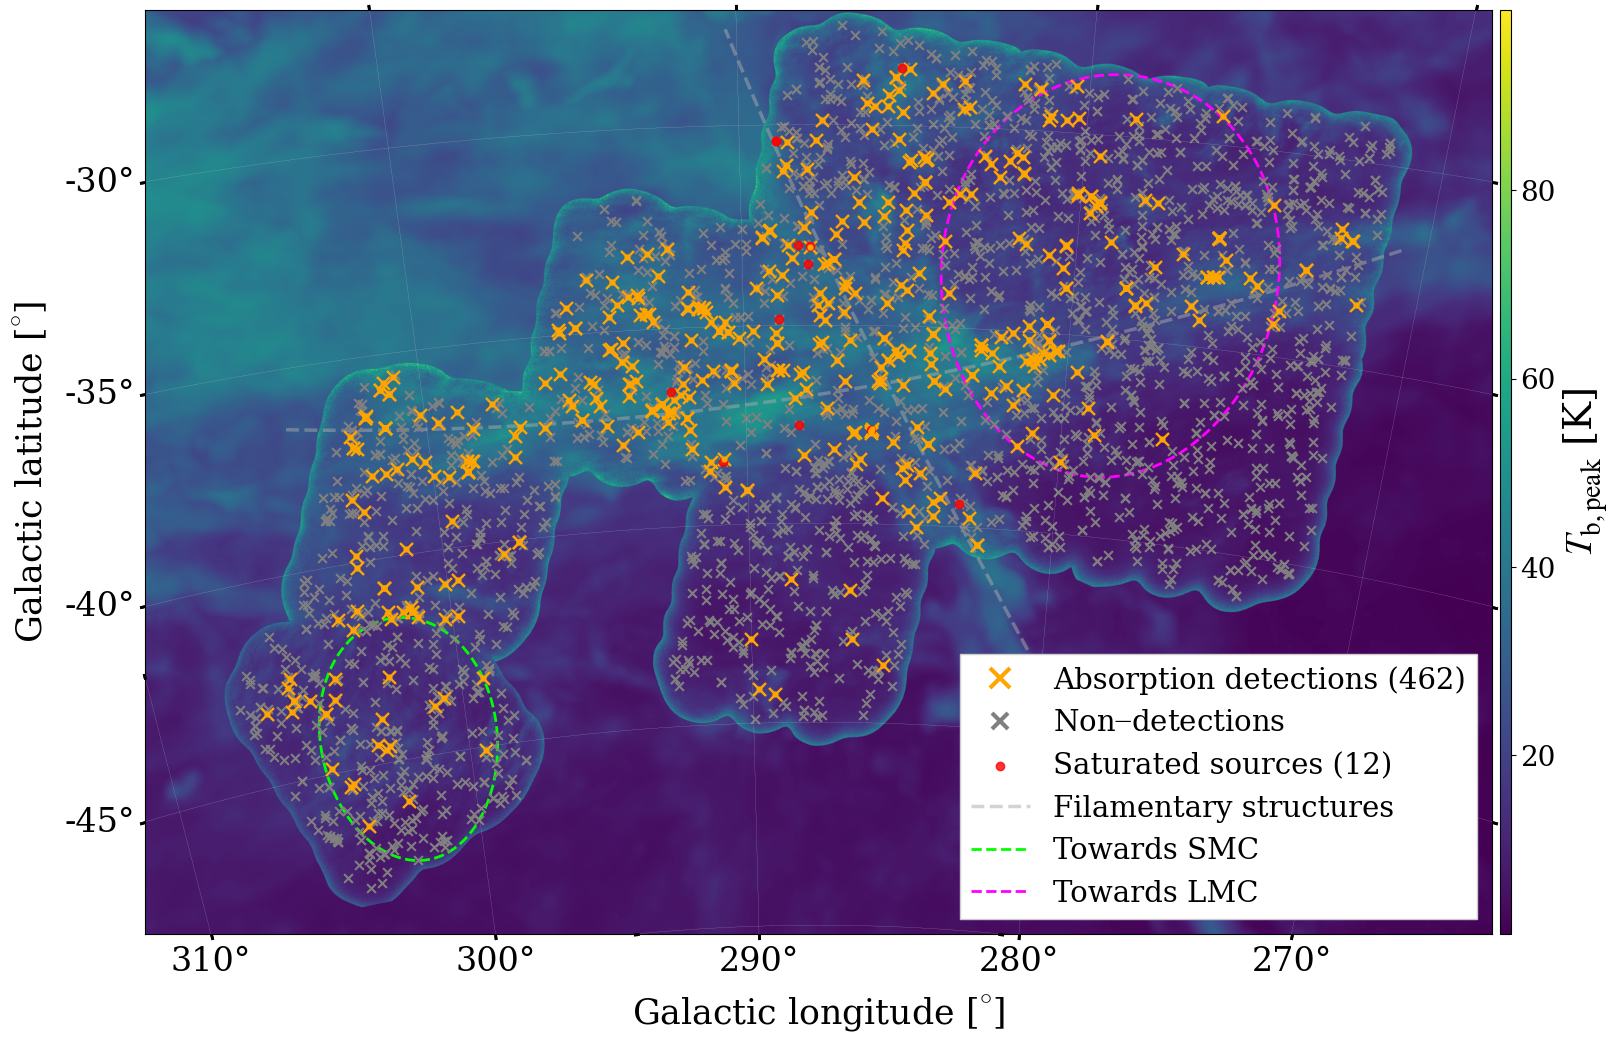

In [99]:
# Plot
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection=WCS(fg_hdr))

# Display the moment map image
im = ax.imshow(tbpeak_data, cmap='viridis')

ax.scatter(det_src_gl, det_src_gb,
                 s=85,
                 transform=ax.get_transform('galactic'),
                 marker='x',
                 c='orange',
                 alpha=1,
                 label='')
ploti, = ax.plot([4000], [100], c='orange', marker='x', markersize=15, mew=3, ls='', lw=0, label=f'Absorption detections ({ndet})')
ploti.set_visible(True)

ax.scatter(src_gl, src_gb,
                 s=40,
                 transform=ax.get_transform('galactic'),
                 marker='x',
                 c='gray',
                 alpha=1,
                 label='')


ploti, = ax.plot([4000], [100], c='gray', marker='x', markersize=12, mew=3, ls='', lw=0, label='Non$-$detections')
ploti.set_visible(True)

ax.scatter(det_src_gl, det_src_gb,
                 s=85,
                 transform=ax.get_transform('galactic'),
                 marker='x',
                 c='orange',
                 alpha=1,
                 )

ax.scatter(sat_gl, sat_gb, s=36, transform=ax.get_transform('galactic'), marker='o', c='r', alpha=0.8, label=f'Saturated sources ({nsat})')
ax.scatter(det_src_gl, det_src_gb, s=12, marker='o', c='orange', alpha=1., transform=ax.get_transform('galactic'), label='')


ax.plot(ch_xcirc, ch_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.5,
        c='darkgray',
        ls='--',
        zorder=0,
        alpha=0.5,
        label='Filamentary structures'
       )


ax.plot(cv_xcirc, cv_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.5,
        c='darkgray',
        ls='--',
        zorder=0,
        alpha=0.5,
        label=''
       )


# # Approximate locations of LMC, SMC
ax.plot(SMC_xcirc,
        SMC_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.,
        zorder=0,
        color='lime',
        ls='--',
        label='Towards SMC'
       )
ax.plot(LMC_xcirc,
        LMC_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.,
        zorder=0,
        color='fuchsia',
        ls='--',
        label='Towards LMC'
       )




# Add axes labels
ax.set_xlabel("Galactic Longitude [degrees]", fontsize=16)
ax.set_ylabel("Galactic Latitude [degrees]", fontsize=16)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', location='right', fraction=0.008, pad=0.005, aspect=85)
cbar.ax.set_ylabel('$T_\mathrm{b,peak}$ [K]', rotation=90, labelpad=5., fontsize=28)
cbar.ax.tick_params(labelsize=20)


# Add axes labels
ax.set_xlabel(r'Galactic longitude [$^{\circ}$]', fontsize=25)
ax.set_ylabel(r'Galactic latitude [$^{\circ}$]', fontsize=25)

ax.tick_params(axis='x', labelsize=24, pad=4)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.legend(loc='lower right', fancybox=False, framealpha=1., labelcolor='k', facecolor='w', fontsize=21)
ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)
plt.show()

In [93]:
tbpeak_data.shape

(3500, 5100)

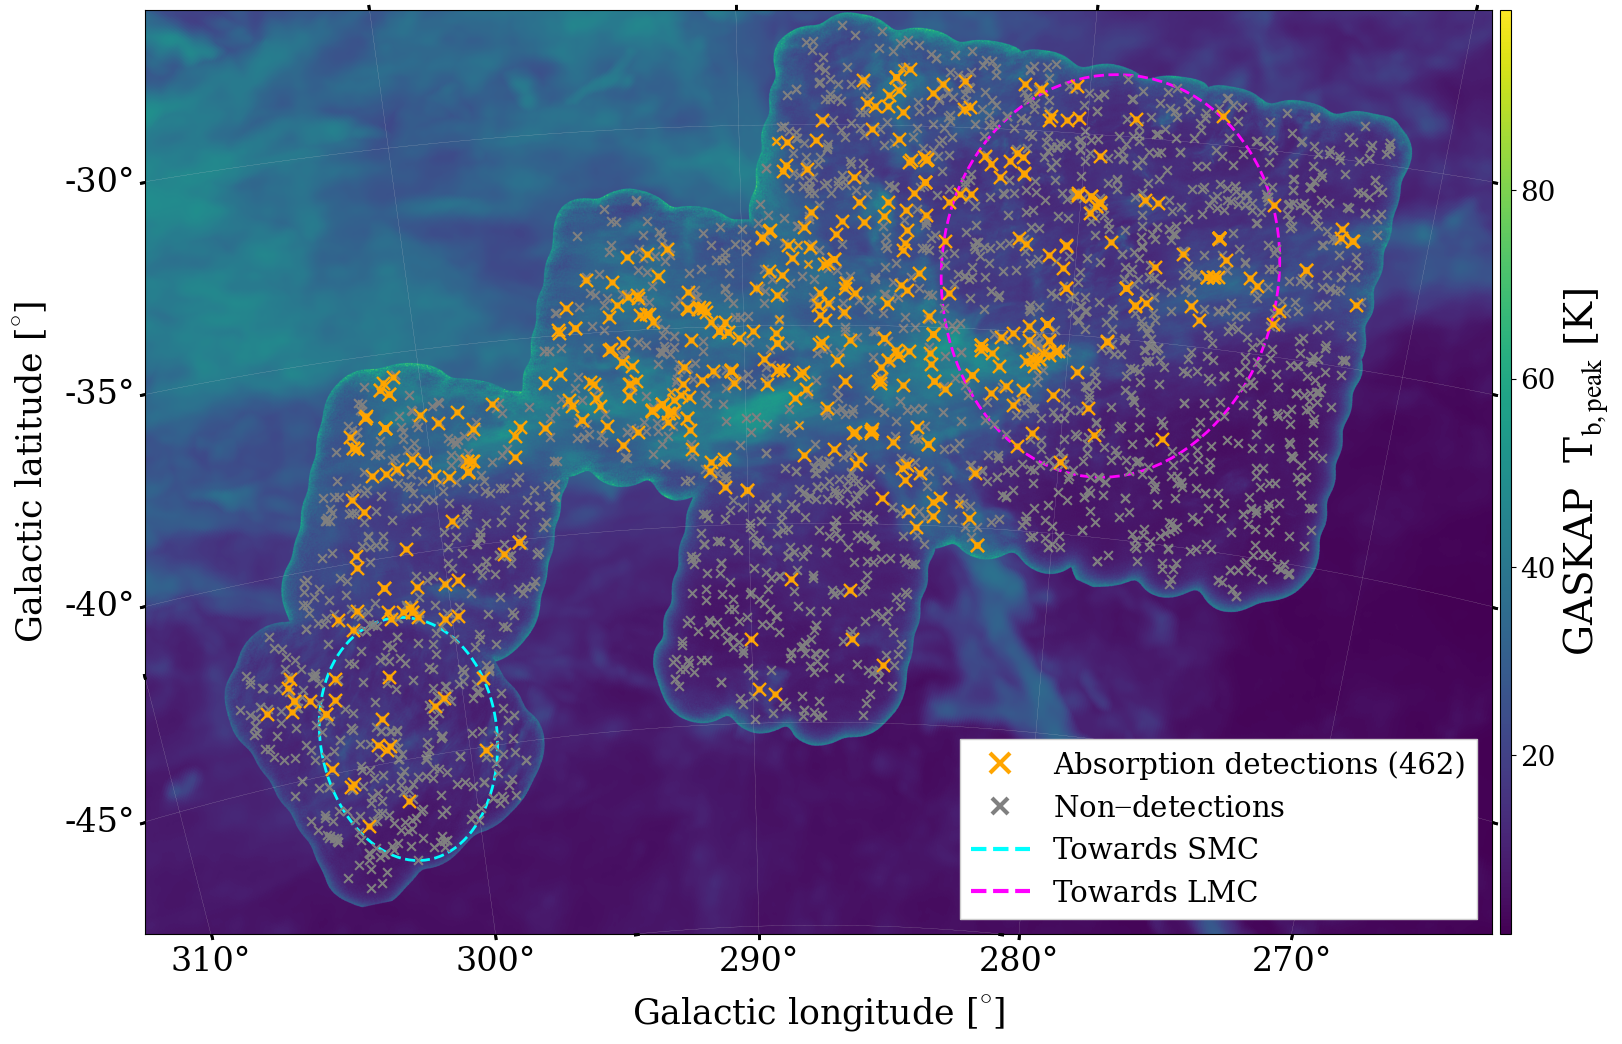

In [94]:
# Plot
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection=WCS(fg_hdr))

# Display the moment map image
im = ax.imshow(tbpeak_data, cmap='viridis')
# ax.invert_yaxis()  # Flips the Y axis
# ax.invert_xaxis()  # Flips the X axis

ax.scatter(det_src_gl, det_src_gb,
                 s=85,
                 transform=ax.get_transform('galactic'),
                 marker='x',
                 c='orange',
                 alpha=1,
                 label='')
ploti, = ax.plot([4000], [100], c='orange', marker='x', markersize=15, mew=3, ls='', lw=0, label=f'Absorption detections ({ndet})')
ploti.set_visible(True)



ax.scatter(src_gl, src_gb,
                 s=40,
                 transform=ax.get_transform('galactic'),
                 marker='x',
                 c='gray', # cadetblue
                 alpha=1,
                 label='')


ploti, = ax.plot([4000], [100], c='gray', marker='x', markersize=12, mew=3, ls='', lw=0, label='Non$-$detections')
ploti.set_visible(True)
# ax.scatter([], [],
#                  s=80,
#                  transform=ax.get_transform('galactic'),
#                  marker='x',
#                  c='gray', # cadetblue
#                  alpha=1,
#                  label='Non$-$detections')

ax.scatter(det_src_gl, det_src_gb,
                 s=85,
                 transform=ax.get_transform('galactic'),
                 marker='x',
                 c='orange',
                 alpha=1,
                 )

ax.scatter(sat_gl, sat_gb, s=30, transform=ax.get_transform('galactic'), marker='x', c='orange', alpha=0.8, label=f'')
ax.scatter(det_src_gl, det_src_gb, s=12, marker='o', c='orange', alpha=1., transform=ax.get_transform('galactic'), label='')



# ax.plot(gl_boundary, gb_boundary, ls='--', c='skyblue', transform=ax.get_transform('galactic'))

# ax.plot(ch_xcirc, ch_ycirc,
#         transform=ax.get_transform('galactic'),
#         lw=2.5,
#         c='darkgray',
#         ls='--',
#         zorder=0,
#         alpha=0.5,
#         label=''
#        )
# ploti, = ax.plot([], [], colors[0], ls=linesty, lw=lw, label=survey_labels[0])
# ploti.set_visible(True)


# ax.plot(cv_xcirc, cv_ycirc,
#         transform=ax.get_transform('galactic'),
#         lw=2.5,
#         c='darkgray',
#         ls='--',
#         zorder=0,
#         alpha=0.5,
#         label=''
#        )


# # Approximate locations of LMC, SMC
ax.plot(SMC_xcirc,
        SMC_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.,
        zorder=0,
        color='cyan',
        ls='--',
        label=''
       )
ploti, = ax.plot([], [], color='cyan', ls='--', lw=3., label='Towards SMC')
ploti.set_visible(True)

ax.plot(LMC_xcirc,
        LMC_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.,
        zorder=0,
        color='fuchsia',
        ls='--',
        label=''
       )
ploti, = ax.plot([], [], color='fuchsia', ls='--', lw=3., label='Towards LMC')
ploti.set_visible(True)




# Title
# ax.set_title(f"LMC: {nfields} fields, {nsrcs} sources", fontsize=18)

# Add axes labels
ax.set_xlabel("Galactic Longitude [degrees]", fontsize=16)
ax.set_ylabel("Galactic Latitude [degrees]", fontsize=16)

## Color bar
# cbar = fig.colorbar(sct, ax=ax, orientation='vertical', fraction=0.02, pad=0.006, aspect=35)
# cbar.ax.set_ylabel('Optical Depth Noise [%]', rotation=90, labelpad=5., fontsize=15)
# cbar.ax.tick_params(labelsize=14)



# ax.set_xlim(lmc_glon[1], lmc_glon[0])
# ax.set_ylim(lmc_glat[0], lmc_glat[1])

# ax.set_xlim(0, 5000)
# ax.set_ylim(500, 4200)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', location='right', fraction=0.008, pad=0.005, aspect=85)
cbar.ax.set_ylabel('GASKAP  T$_\mathrm{b,peak}$ [K]', rotation=90, labelpad=5., fontsize=28)
cbar.ax.tick_params(labelsize=20)


# Title
# ax.set_title(f"LMC: {n_fields} fields, {n_sources} sources", fontsize=18)

# Add axes labels
ax.set_xlabel(r'Galactic longitude [$^{\circ}$]', fontsize=25)
ax.set_ylabel(r'Galactic latitude [$^{\circ}$]', fontsize=25)

ax.tick_params(axis='x', labelsize=24, pad=4)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)




# Overlay set of RA/Dec Axes
# overlay = ax.get_coords_overlay('galactic')
# overlay.grid(color='white', ls='dotted', lw=0.3)
# overlay[0].set_axislabel('Galactic Longitude [deg]', fontsize=16)
# overlay[1].set_axislabel('Galactic Latitude [deg]', fontsize=16)

ax.legend(loc='lower right', fancybox=False, framealpha=1., labelcolor='k', facecolor='w', fontsize=21)
ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)
plt.show()

In [ ]:
fg_wcs = WCS(fg_hdr)
fg_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN'  'GLAT-TAN'  
CRVAL : 287.7000000000004  -38.69999999999963  
CRPIX : 2550.0  1750.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00666666  0.00666666  
NAXIS : 5100  3500

# Detections

In [ ]:
field_det = {
    0 : [30665, 'gaskap_phase2_abs_catalogue_field0_30665_dr3.csv', ['J005337-723143']], # SMC
    1 : [38373, 'gaskap_phase2_abs_catalogue_field1_38373_dr3.csv', ['J044512-654707']],
    2 : [38791, 'gaskap_phase2_abs_catalogue_field2_38791_dr3.csv', ['J054030-631513']],
    3 : [38814, 'gaskap_phase2_abs_catalogue_field3_38814_dr3.csv', ['J035150-695934']],
    4 : [33047, 'gaskap_phase2_abs_catalogue_field4_33047_dr3.csv', ['J060111-703609']],
    5 : [38758, 'gaskap_phase2_abs_catalogue_field5_38758_dr3.csv', ['J040848-750719']],
    6 : [38845, 'gaskap_phase2_abs_catalogue_field6_38845_dr3.csv', ['J045438-751726']],
    7 : [38509, 'gaskap_phase2_abs_catalogue_field7_38509_dr3.csv', ['J031155-765150']],
    8 : [38466, 'gaskap_phase2_abs_catalogue_field8_38466_dr3.csv', ['J025246-710435']],
    9 : [38215, 'gaskap_phase2_abs_catalogue_field9_38215_dr3.csv', ['J012256-751507']]
}

# Read LMC absorption summary tableL: DR3

In [ ]:
peak_cat_dr3_file = abs_dr3_data_path / 'gaskap_absorption_v0.3b.vot'
abs_df = fcn.votable_to_pandas(peak_cat_dr3_file)
nrows, ncols = abs_df.shape
print(f'Number of rows {nrows},\n Number of columns: {ncols}')
abs_df.head(5)

Number of rows 1059,
 Number of columns: 27


,src_id,sbid,comp_name,abs_name,ra,dec,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,start_vel,end_vel,length,min_optical_depth,e_min_optical_depth,peak_tau,e_peak_tau,max_sigma,ew,e_ew
0,0,30665,J005611-710706,J005611-710706_150,14.047482,-71.118446,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.80,4.215,33.869999,150.673036,138.946946,13,0.913717,0.005705,0.090235,0.006225,15.122845,0.686081,0.020185
1,0,30665,J005611-710706,J005611-710706_1,14.047482,-71.118446,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.80,4.215,33.869999,1.165389,-2.743308,5,0.898914,0.005135,0.106568,0.005696,19.687183,0.255683,0.011083
2,8,30665,J011049-731427,J011049-731427_179,17.707468,-73.240921,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.79,5.350,54.860001,179.075688,177.121334,3,0.959491,0.007145,0.041352,0.007419,5.669699,0.101240,0.012342
3,8,30665,J011049-731427,J011049-731427_175,17.707468,-73.240921,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.79,5.350,54.860001,175.166980,173.212625,3,0.959115,0.007647,0.041744,0.007942,5.346187,0.110211,0.013172
4,8,30665,J011049-731427,J011049-731427_171,17.707468,-73.240921,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.79,5.350,54.860001,171.258271,150.737551,22,0.547128,0.008093,0.603072,0.014683,55.958978,5.948881,0.036829


In [ ]:
n_abs = abs_df['comp_name'].unique().shape[0]
print(f'Number of absorption toward LMC (both MW + LMC): {n_abs}')
print(f'General absorption detection rate: {100.*np.round(n_abs/nsrcs, 4)} %')

Number of absorption toward LMC (both MW + LMC): 712
General absorption detection rate: 26.229999999999997 %


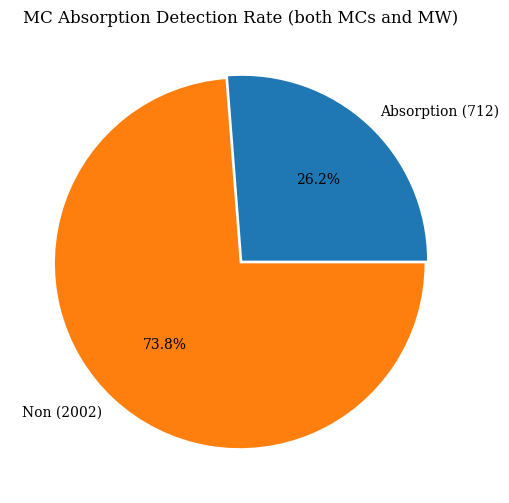

In [ ]:
colors = ['g', 'r']
explode = [0.01]*2
labels = ['Absorption', 'Non']
dect_counts = [n_abs, nsrcs-n_abs]
labels = [labels[i]+' (' + str(dect_counts[i]) + ')' for i in range(2)]
pect = [100.*np.round(n_abs/nsrcs, 4), 100. - 100.*np.round(n_abs/nsrcs, 4)]

plt.figure(figsize=(6,6))
plt.pie(pect,
        colors=None,
        labels=labels,
        explode=explode,
        autopct='%1.1f%%',
        shadow=False)

plt.title('MC Absorption Detection Rate (both MCs and MW)')
plt.show()

# Foreground detection rate

In [ ]:
sources_mw = det_df['comp_name'].unique()
print(f'Number of sources with absorption detections in Foreground (MW): {len(sources_mw)}')
sources_mw[:5]

Number of sources with absorption detections in Foreground (MW): 462


array(['J005611-710706', 'J011049-731427', 'J004048-714600',
       'J005732-741242', 'J004741-753010'], dtype=object)

In [ ]:
# All sources
print(f'Number of sources toward LMC: {nsrcs}')
print(f'Sources: {sources}')

Number of sources toward LMC: 2714
Sources: ['J005611-710706' 'J011049-731427' 'J011056-731406' ... 'J045340-751015'
 'J060302-715904' 'J051901-715032']


In [ ]:
print(f'Number of MW absorption detections: {ndet}')
print(f'MW absorption detection rate: {100.*np.round(ndet/nsrcs, 4)} %')

Number of MW absorption detections: 462
MW absorption detection rate: 17.02 %


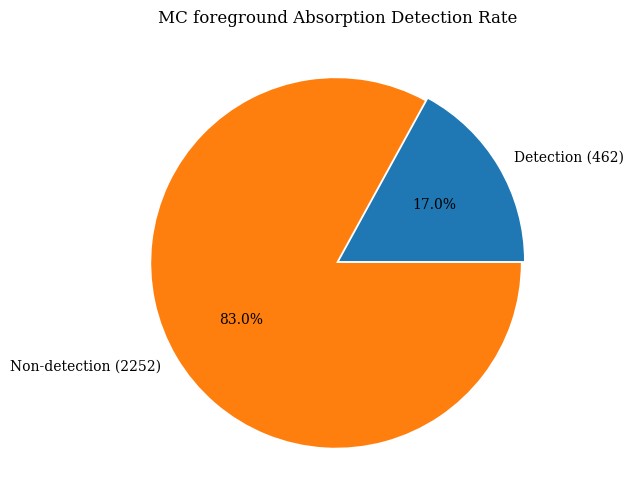

In [ ]:
colors = ['g', 'r']
explode = [0.01]*2
labels = ['Detection', 'Non-detection']
dect_counts = [ndet, nsrcs-ndet]
labels = [labels[i]+' (' + str(dect_counts[i]) + ')' for i in range(2)]
pect = [100.*np.round(ndet/nsrcs, 4), 100. - 100.*np.round(ndet/nsrcs, 4)]

plt.figure(figsize=(6,6))
plt.pie(pect,
        colors=None,
        labels=labels,
        explode=explode,
        autopct='%1.1f%%',
        shadow=False)

plt.title('MC foreground Absorption Detection Rate')
plt.show()